In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("clean_data.csv")
data.head()

,gameId,season,gameType,gameDate,homeTeam,awayTeam,period,periodTime,byTeam,eventType,shotType,coordinateX,coordinateY,shooterName,goalieName,strength,emptyNet
0,2016020001,2016,R,2016-10-12,OTT,TOR,1,01:11,TOR,SHOT,Wrist Shot,-77.0,5.0,Mitchell Marner,Craig Anderson,False,False
1,2016020001,2016,R,2016-10-12,OTT,TOR,1,02:53,OTT,SHOT,Wrist Shot,86.0,13.0,Chris Kelly,Frederik Andersen,False,False
2,2016020001,2016,R,2016-10-12,OTT,TOR,1,04:01,OTT,SHOT,Wrist Shot,23.0,-38.0,Cody Ceci,Frederik Andersen,False,False
3,2016020001,2016,R,2016-10-12,OTT,TOR,1,04:46,OTT,SHOT,Slap Shot,33.0,-15.0,Erik Karlsson,Frederik Andersen,False,False
4,2016020001,2016,R,2016-10-12,OTT,TOR,1,06:46,TOR,SHOT,Wrist Shot,-34.0,28.0,Martin Marincin,Craig Anderson,False,False


In [3]:
import numpy as np

def adjust_coordinates(x, y):
    if x < 0:
        return -x, -y
    return x, y

# Appliquer la fonction adjust_coordinates pour ajuster les coordonnées des tirs
adjustedCoordinates = np.array(data.apply(lambda row: adjust_coordinates(row['coordinateX'], row['coordinateY']), axis=1).tolist())

# Mettre à jour le jeu de données avec les coordonnées ajustées
data['adjustedX'] = adjustedCoordinates[:, 0]
data['adjustedY'] = adjustedCoordinates[:, 1]

In [12]:
data = data[(data["adjustedX"].isna() == False) & (data["adjustedY"].isna() == False)]

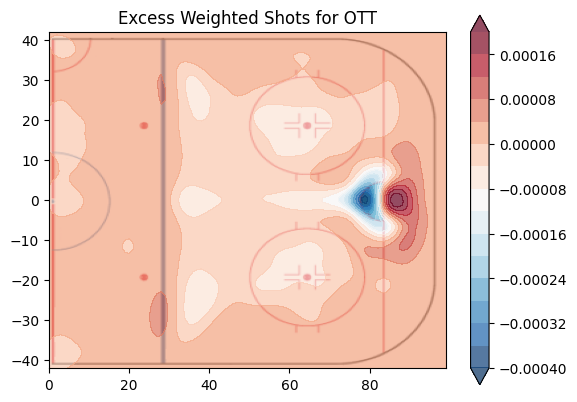

In [21]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the rink image
rink_image = mpimg.imread('Half_ice_hockey_rink-right.png')

# Define the team of interest
TEAM_OF_INTEREST = 'OTT'

# Compute league-wide KDE
gridsize = 100
x_league, y_league = data["adjustedX"].values, data["adjustedY"].values

# Compute the KDE for the league
kde_league = gaussian_kde(np.vstack([x_league, y_league]))
x_grid, y_grid = np.mgrid[x_league.min():x_league.max():gridsize*1j, 
                          y_league.min():y_league.max():gridsize*1j]
league_values = kde_league(np.vstack([x_grid.ravel(), y_grid.ravel()]))

# Compute KDE for the specific team
team_shots = data[data['byTeam'] == TEAM_OF_INTEREST]
x_team, y_team = team_shots['adjustedX'].values, team_shots['adjustedY'].values
kde_team = gaussian_kde(np.vstack([x_team, y_team]))
team_values = kde_team(np.vstack([x_grid.ravel(), y_grid.ravel()]))

excess_kde = team_values - league_values

# Visualization

plt.imshow(rink_image, extent=[x_league.min(), x_league.max(), y_league.min(), y_league.max()])  # Display the rink image

# Contour plot
contour = plt.contourf(x_grid, y_grid, excess_kde.reshape(gridsize, gridsize), 
                       cmap='RdBu_r', levels=20, extend='both', alpha=0.7)  # Added alpha for transparency
plt.colorbar(contour)

plt.title(f'Excess Weighted Shots for {TEAM_OF_INTEREST}')
plt.xlim(x_league.min(), x_league.max())
plt.ylim(y_league.min(), y_league.max())
plt.gca().set_aspect('equal', adjustable='box')  # To keep the rink aspect ratio
plt.show()